# Homework 3

**Author**: Chrisiaan van Roon - 11122854

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as st
from scipy.optimize import minimize
from operator import itemgetter

plt.rcParams['figure.figsize'] = 18, 8

## Problem 1

### Question 1

In [2]:
def randpair(mu_x, sigma_x, alpha, beta, sigma_y_x):
    x = np.random.normal(mu_x, sigma_x)
    y = np.random.normal(alpha + (beta * x), sigma_y_x)
    return (x,y)

### Question 2

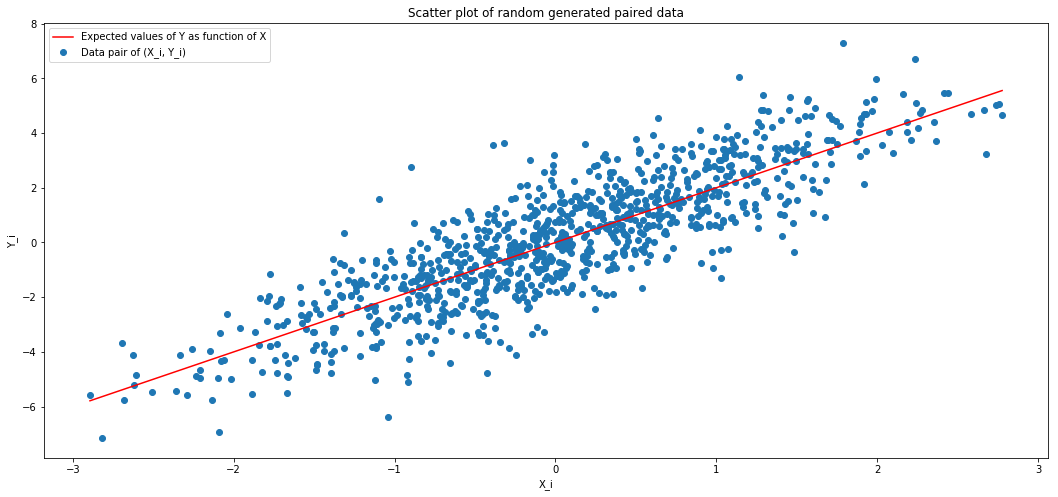

In [3]:
mu_x = 0
sigma_x = 1
alpha = 0
beta = 2
sigma_y_x = 1.25

def mu_i(alpha, beta, x_i):
    return alpha + (beta  * x_i)

s = np.array([randpair(mu_x, sigma_x, alpha, beta, sigma_y_x) for i in range(0, 10**3)])
x = np.linspace(min(s[...,0]), max(s[...,0]), 10**3)
y = mu_i(alpha, beta, x)


plt.scatter(s[...,0], s[...,1], label='Data pair of (X_i, Y_i)')
plt.plot(x,y, label='Expected values of Y as function of X', color='red')

plt.title('Scatter plot of random generated paired data')
plt.xlabel('X_i')
plt.ylabel('Y_i')
plt.legend(loc='upper left')
plt.show()

### Question 3

Given that: 
$$Pr(\vec{X}, \vec{Y} \mid \hat{\alpha}, \hat{\beta}, \hat{\sigma}_{Y \mid X})$$  
Using the generalized chain rule:
$$Pr(A, B) = Pr(B \mid A) \cdot Pr(A)$$
$$= Pr(\vec{Y} \mid \vec{X}, \hat{\alpha}, \hat{\beta}, \hat{\sigma}_{Y \mid X}) \cdot Pr(\vec{X} \mid \hat{\alpha}, \hat{\beta}, \hat{\sigma}_{Y \mid X})$$

Because this last term is constant we can state the following:
$$=Pr(\vec{Y} \mid \vec{X}, \hat{\alpha}, \hat{\beta}, \hat{\sigma}_{Y \mid X})$$
And now we compute the log-likelihood:
$$=log\; L(\vec{Y} \mid \vec{X}, \hat{\alpha}, \hat{\beta}, \hat{\sigma}_{Y \mid X})$$

### Question 4

That the individual data samples are conditional independent. When using this to rewrite the expression for maximizing the log-likelihood we find the following computable expression:
$$log\;L(\vec{Y} \mid \vec{X}, \hat{\alpha}, \hat{\beta}, \hat{sigma}_{Y \mid X}) = \sum_{i} log\;L(y_i \mid x_i, \hat{\alpha}, \hat{\beta}, \hat{\sigma}_{Y \mid X})$$

### Question 5

In [4]:
def loglikelihood_lrm(alpha, beta, sigma_y, sample):
    sample_x = np.array(sample)[...,0]
    sample_y = np.array(sample)[...,1]

    result = 0
    for i in range(0, len(sample)):
        mu = mu_i(alpha, beta, sample_x[i])
        result += (sample_y[i] - mu)**2

    n = len(sample)
    return -n/2 * np.log(2*np.pi) - n/2 * np.log(sigma_y**2) - 1/(2 * sigma_y**2) * result

print(loglikelihood_lrm(0, 2, 1.25, s))

-1642.26472105


### Question 6

In [5]:
def own_fit_lrm(sample):
    param_alpha = np.linspace(0, 4, 25)
    param_beta = np.linspace(0, 4, 25)
    param_sigma = np.linspace(0.001, 4, 25)
        
    likelihoods = []
    for i in param_alpha:
        for j in param_beta:
            for k in param_sigma:
                likelihoods.append((loglikelihood_lrm(i, j, k, sample), i, j, k))
    
    tmp = list(map(itemgetter(0), likelihoods))
    max_likelihood = max(tmp)
    index = tmp.index(max_likelihood)
    alpha = likelihoods[index][1]
    beta = likelihoods[index][2]
    sigma_y_x = likelihoods[index][3]
    
    return alpha, beta, sigma_y_x

### Question 7

In [6]:
alpha, beta, sigma_y_x = own_fit_lrm(s)
print(alpha)
print(beta)
print(sigma_y_x)

0.0
2.0
1.334


As we can see the parameters that are returned by the `fit_lrm` function are approximated very close to the true value of the parameters, which are $\alpha = 0, \beta = 2, \sigma = 1.25$. The absolute difference is:

In [7]:
print('For alpha: ' + str(abs(alpha - 0)))
print('For beta: ' + str(abs(beta - 2)))
print('For gamma: ' + str(abs(sigma_y_x - 1.25)))

For alpha: 0.0
For beta: 0.0
For gamma: 0.084


### Question 8

In [8]:
def mean(data):
    return sum(data) / len(data)

def std_dev(data):
    mean_value = mean(data)
    diff = [x - mean_value for x in data]
    diff_squared = [x ** 2 for x in diff]
    return np.sqrt(sum(diff_squared) / len(data))

def fit_lrm(data):
    optres = minimize(lambda tup: -loglikelihood_lrm(*tup, data), (0, 0, 1),
                                                     bounds=((None, None), (None, None), (0.001, None)))
    return optres.x

In [9]:
mu_x = mean(s[...,0])
sigma_x = std_dev(s[...,0])

alpha, beta, sigma_y_x = fit_lrm(s)

n = 10**3
N = 10**3

params = np.array([fit_lrm([randpair(mu_x, sigma_x, alpha, beta, sigma_y_x) for __ in range(n)]) for _ in range(N)])

In [10]:
def lineair_percentile(values, alpha):
    values.sort()
    n = len(values)
    floor = math.floor(n*alpha)
    ceil = math.ceil(n*alpha)

    if floor == ceil:
        return values[int(n * alpha)]
    else:
        return (values[floor - 1] * (ceil - (n * alpha))) + (values[ceil - 1] * ((n * alpha) - floor))

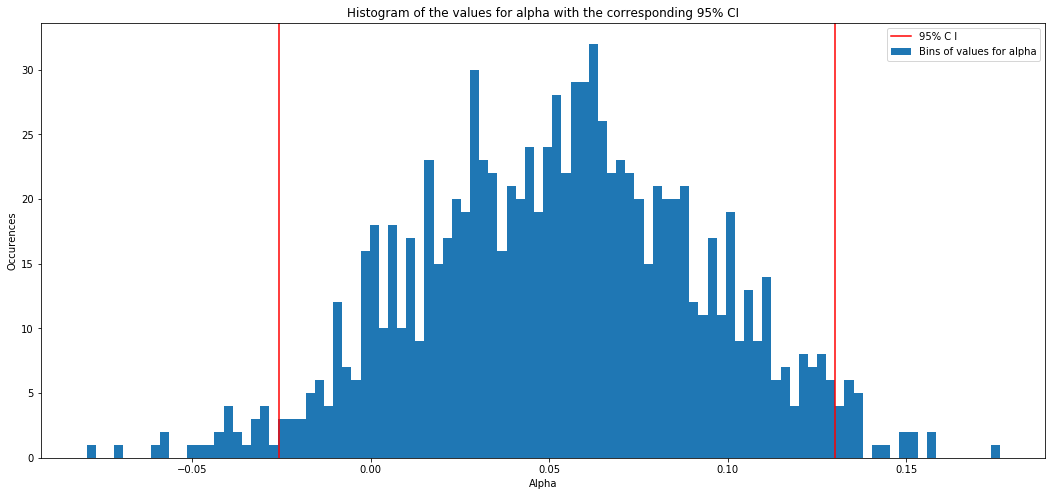

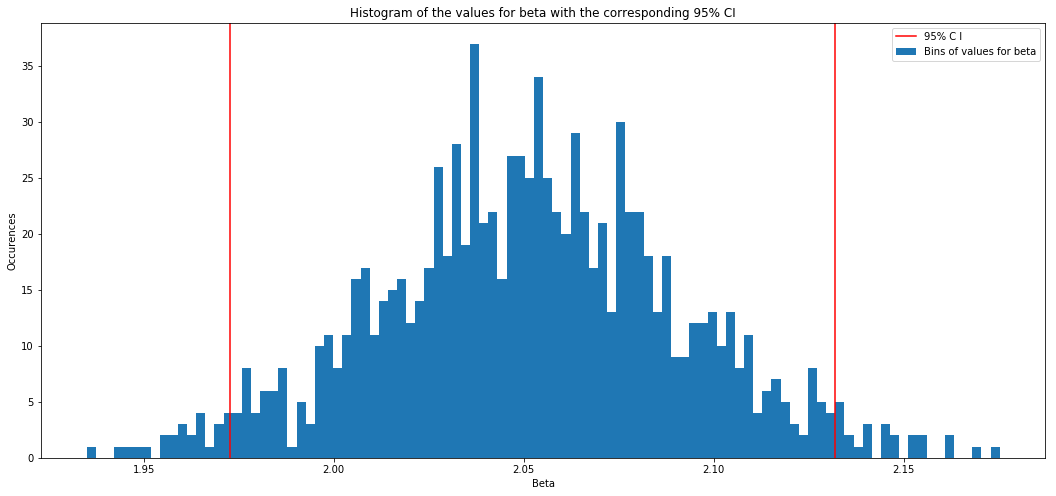

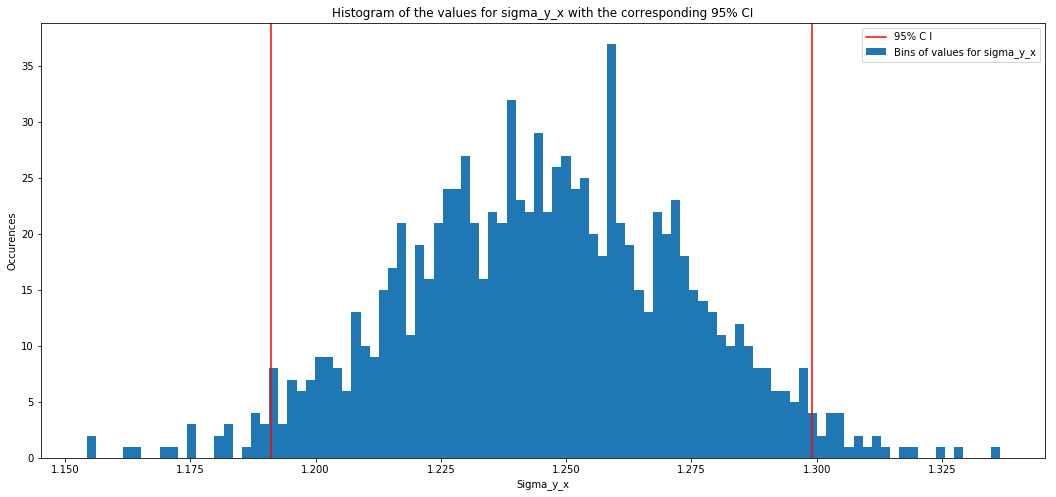

In [11]:
def plot_hist_with_ci(samples, bins, upper_bound, lower_bound, labels):
    plt.title(labels[0])
    plt.xlabel(labels[1])
    plt.ylabel(labels[2])
    plt.hist(samples, bins, label=labels[3])
    plt.axvline(x=upper_bound, color='red')
    plt.axvline(x=lower_bound, color='red', label=labels[4])
    plt.legend()
    plt.show()
    
params_a = params[...,0]
params_b = params[...,1]
params_s = params[...,2]

a_ci_lower = lineair_percentile(params_a, 0.025)
a_ci_upper = lineair_percentile(params_a, 0.975)
b_ci_lower = lineair_percentile(params_b, 0.025)
b_ci_upper = lineair_percentile(params_b, 0.975)
s_ci_lower = lineair_percentile(params_s, 0.025)
s_ci_upper = lineair_percentile(params_s, 0.975)


labels_a=['Histogram of the values for alpha with the corresponding 95% CI',
          'Alpha',
          'Occurences',
          'Bins of values for alpha',
          '95% C I']

labels_b=['Histogram of the values for beta with the corresponding 95% CI',
          'Beta',
          'Occurences',
          'Bins of values for beta',
          '95% C I']

labels_s=['Histogram of the values for sigma_y_x with the corresponding 95% CI',
          'Sigma_y_x',
          'Occurences',
          'Bins of values for sigma_y_x',
          '95% C I']

plot_hist_with_ci(params_a, 100, a_ci_upper, a_ci_lower, labels_a)
plot_hist_with_ci(params_b, 100, b_ci_upper, b_ci_lower, labels_b)
plot_hist_with_ci(params_s, 100, s_ci_upper, s_ci_lower, labels_s)

No, as we can see in the histogram the slope is approximately somewhere around 2. Having a slope of $\beta = 0$ is not a plausible parameter at all as we look at having n samples. For this case the null-hyptohesis would be:  
* $H_0$: A slope of $\beta$ is a plausible population parameter.   
  
When taking a value of $\beta = 0$ we reject this null-hypothesis. Take a look at the second histogram displayed above and see that this value of $\beta$ is outside our $95\%$ Confidence Interval.

### Question 9

In [12]:
n = 3
N = 10**3

params = np.array([fit_lrm([randpair(mu_x, sigma_x, alpha, beta, sigma_y_x) for __ in range(n)]) for _ in range(N)])

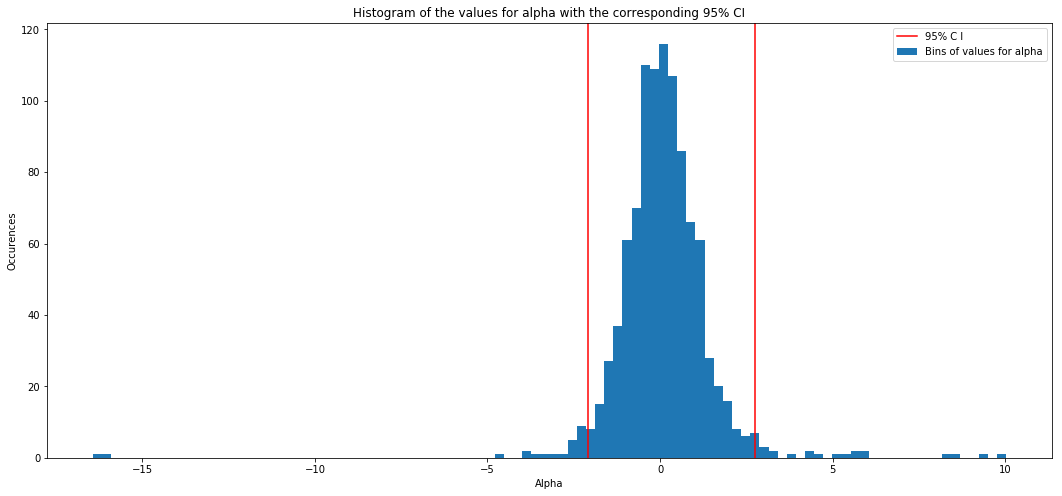

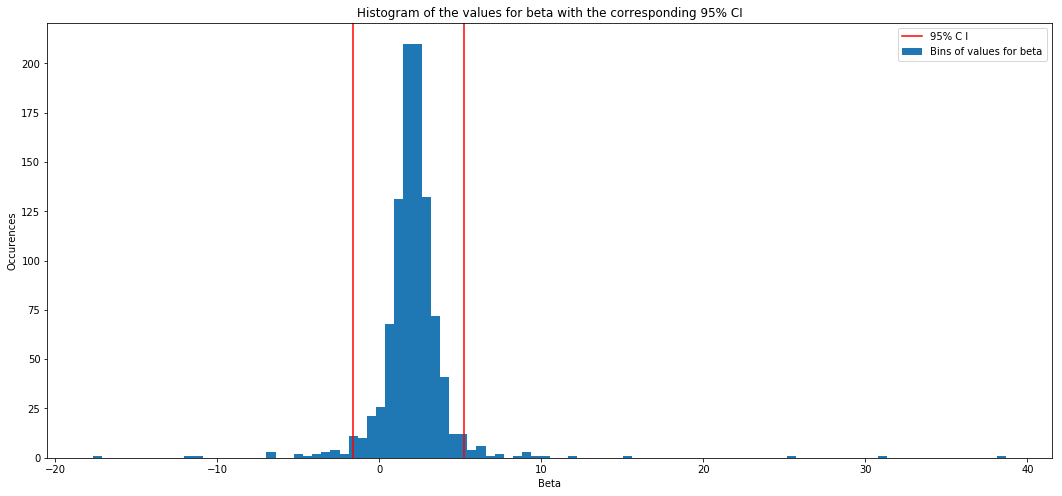

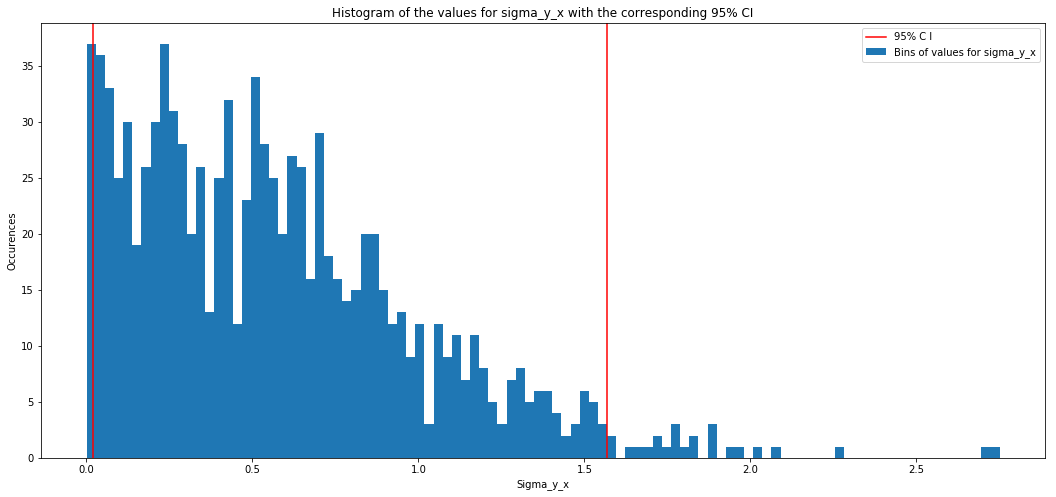

In [13]:
params_a = params[...,0]
params_b = params[...,1]
params_s = params[...,2]

a_ci_lower_s = lineair_percentile(params_a, 0.025)
a_ci_upper_s = lineair_percentile(params_a, 0.975)
b_ci_lower_s = lineair_percentile(params_b, 0.025)
b_ci_upper_s = lineair_percentile(params_b, 0.975)
s_ci_lower_s = lineair_percentile(params_s, 0.025)
s_ci_upper_s = lineair_percentile(params_s, 0.975)

plot_hist_with_ci(params_a, 100, a_ci_upper_s, a_ci_lower_s, labels_a)
plot_hist_with_ci(params_b, 100, b_ci_upper_s, b_ci_lower_s, labels_b)
plot_hist_with_ci(params_s, 100, s_ci_upper_s, s_ci_lower_s, labels_s)

When taking a much smaller sample size, we can see that our null-hypothesis looks to be true. This is what you expect when thinking of the way the value for $\beta$ is computed. When having such a small dataset, it is way harder to discover a tendency between the data points dependent on the parameters and thus it will results in a regression line with slope $= 0$.

### Question 10

In [14]:
def bootstrap_lrm(sample):
    bootstrap_sample = [sample[np.random.randint(0, len(sample) - 1)] for _ in range(0, 10**3)]
    return fit_lrm(bootstrap_sample)

In [15]:
params_bootstrap = np.array([bootstrap_lrm(s) for _ in range(0, 10**3)])

In [16]:
params_a = params_bootstrap[...,0]
params_b = params_bootstrap[...,1]
params_s = params_bootstrap[...,2]

a_ci_lower_bootstrap = lineair_percentile(params_a, 0.025)
a_ci_upper_bootstrap = lineair_percentile(params_a, 0.975)
b_ci_lower_bootstrap = lineair_percentile(params_b, 0.025)
b_ci_upper_bootstrap = lineair_percentile(params_b, 0.975)
s_ci_lower_bootstrap = lineair_percentile(params_s, 0.025)
s_ci_upper_bootstrap = lineair_percentile(params_s, 0.975)

print('The difference between the estimated CI using bootstrap and the answer from Q8 for\n alpha lower boundary: ' +\
      str(abs(a_ci_lower_bootstrap - a_ci_lower)))
print('The difference between the estimated CI using bootstrap and the answer from Q8 for\n alpha upper boundary: ' +\
      str(abs(a_ci_upper_bootstrap - a_ci_upper)))
print('The difference between the estimated CI using bootstrap and the answer from Q8 for\n beta lower boundary: ' +\
      str(abs(b_ci_lower_bootstrap - b_ci_lower)))
print('The difference between the estimated CI using bootstrap and the answer from Q8 for\n beta upper boundary: ' +\
      str(abs(b_ci_upper_bootstrap - b_ci_upper)))
print('The difference between the estimated CI using bootstrap and the answer from Q8 for\n sigma_y_x lower boundary: ' +\
      str(abs(s_ci_lower_bootstrap - s_ci_lower)))
print('The difference between the estimated CI using bootstrap and the answer from Q8 for\n sigma_y_x upper boundary: ' +\
      str(abs(s_ci_upper_bootstrap - s_ci_upper)))

The difference between the estimated CI using bootstrap and the answer from Q8 for
 alpha lower boundary: 0.00723426613619
The difference between the estimated CI using bootstrap and the answer from Q8 for
 alpha upper boundary: 0.000353286923513
The difference between the estimated CI using bootstrap and the answer from Q8 for
 beta lower boundary: 0.00194493863476
The difference between the estimated CI using bootstrap and the answer from Q8 for
 beta upper boundary: 0.00482823155936
The difference between the estimated CI using bootstrap and the answer from Q8 for
 sigma_y_x lower boundary: 0.000840248231532
The difference between the estimated CI using bootstrap and the answer from Q8 for
 sigma_y_x upper boundary: 0.00608664184726


We can see that all of the boundaries of the CI's for the different parameters are approximated closely.

### Question 11

Because the prediction of values of $Y$ is correlated with the value of $X$ in the following way:
$$Y_i = \alpha + \beta \cdot X_i$$
And thus when $\beta$ is equal to zero, $Y_i$ is no longer dependent of $X_i$ and thus knowing the value $X_i$ does not give extra information about the true value of $Y_i$

### Question 12

In [17]:
def variance(sample):
    sample_mean = mean(sample)
    result = 0
    for i in sample:
        result += (i - sample_mean)**2

    return result / (len(sample) - 1)

variance_y = variance(s[...,1])
print('Variance of Y: ' + str(variance_y))

residuals = s[...,1] - (alpha + (beta * s[...,0]))
variance_residuals = variance(residuals)
print('Variance of residuals: ' + str(variance_residuals))
print('Percent of reduction is: ' + str(((variance_y - variance_residuals) / variance_y)*100))

Variance of Y: 5.6972628432
Variance of residuals: 1.55873897435
Percent of reduction is: 72.6405641227


### Question 13

In [18]:
residuals = s[...,1] - (alpha + (-beta * s[...,0]))
variance_residuals = variance(residuals)
print('Percent of reduction is: ' + str(((variance_y - variance_residuals) / variance_y)*100))

Percent of reduction is: -217.92168914


We having a negative value for the slope($\beta$) we assume that $X$ and $Y$ are negatively correlated and that there will be a negative tendancy in the regression line. When predicating values for $Y$ following using a negative value for $\beta$ we will see that all our predicted values are far away from the real values of $Y$ and thus the percent of reduction will be a high negative number, which implies the variance only increased instead of being reduced.

### Question 14

The standard deviation of Y dependent on X. When the standard deviation off Y given a certain X is very small, you will have $Y$ values that do not differ much from the regression line. When all points are closer to each other the lineair dependecy will be higher and thus there will be a higher goodness of fit.

### Question 15

In [19]:
def pearson_coefficient(sample):
    sample_x = sample[...,0]
    sample_y = sample[...,1]
    mean_x = mean(sample_x)
    mean_y = mean(sample_y)
    
    return sum((sample_x - mean_x) * (sample_y - mean_y)) / \
                (np.sqrt(sum((sample_x - mean_x) ** 2)) * np.sqrt(sum((sample_y - mean_y) ** 2)))

residuals = s[...,1] - (alpha + (beta * s[...,0]))
variance_residuals = variance(residuals)
pc = pearson_coefficient(s)
print('r = ' + str(pc))
print('r^2 = ' + str(pc ** 2))
print('r^2 * 100 = ' + str(pc ** 2 * 100) +  '(Q15) = ' + str((((variance_y - variance_residuals) / variance_y)*100)) + '(Q12)')

r = 0.852294339549
r^2 = 0.726405641227
r^2 * 100 = 72.6405641227(Q15) = 72.6405641227(Q12)


We can see that the value of $r^2$ is exactly the same as the percentage calculated in question 12. In question 12 we multiplied our answer with 100 to create a percentage instead of a factor between $0$ and $1$. In report we still make use of $r$ instead of $r^2$ because the two have a different meaning. $r$ is the strength of lineair dependence of two random variables $X$ and $Y$ while $r^2$ is the coefficient of determination, which represents the accuracy with we can state that two random variables are lineair dependent.

### Question 16

For a value of $\beta = 0$ you would expect the pearson product-moment coefficient to be close to zero, because in that case we cannot improve prediction of $Y$ when knowing $X$ and thus would result in a low lineair dependecy rate.

In [20]:
beta = 0
s = np.array([randpair(mu_x, sigma_x, alpha, beta, sigma_y_x) for i in range(0, 10**3)])
print(pearson_coefficient(s)**2)

0.000122723378027


When having a $\sigma_{Y \mid X}=0$ you would expect the value of the pearson product-moment coefficient to be very close to $1$ or $-1$. When having a $\beta \neq 0$ both of the variables are lineair depedent in some way, together with a standard deviation of 0 you can say that the estimated value is equal to the theoretical value. Both variables are thus completely lineair dependent.

In [21]:
sigma_y_x = 0
beta = np.random.uniform(-2, 2)
s = np.array([randpair(mu_x, sigma_x, alpha, beta, sigma_y_x) for i in range(0, 10**3)])
print(pearson_coefficient(s)**2)

1.0


When increasing the value $sigma_{Y \mid X}$ while keeping $\beta \neq 0$ constant, you expect the value of the pearson product-moment coefficient to move away from 1 towards $0$. When increasing $\sigma_{Y \mid X}$ both variables become more and more independent.

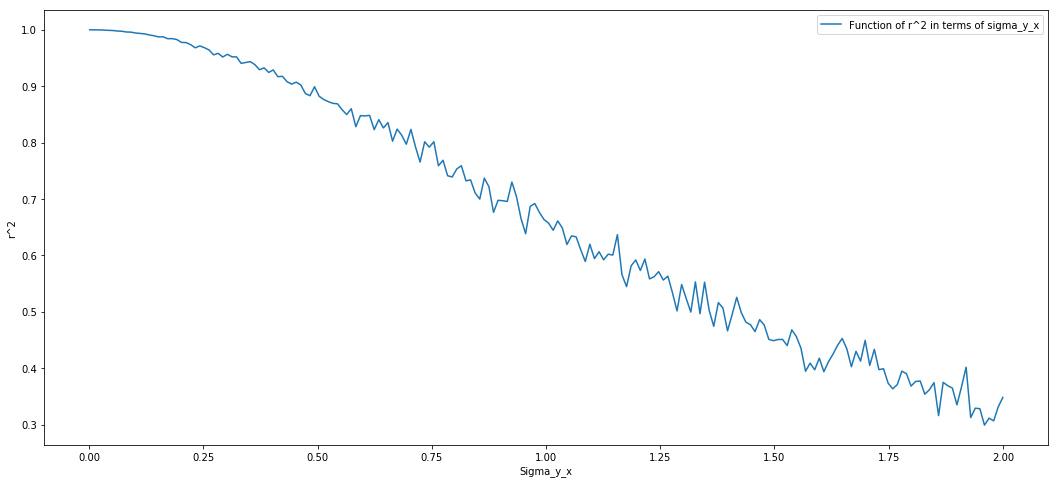

In [22]:
def inc_sigma(x):
    y = []
    beta = np.random.uniform(-2, 2)
    for i in x:
        s = np.array([randpair(mu_x, sigma_x, alpha, beta, i) for _ in range(0, 10**3)])
        y.append(pearson_coefficient(s) **2)
    
    return y

x = np.linspace(0.001, 2, 200)
beta = np.random.uniform(-2, 2)
y = inc_sigma(x)
plt.plot(x,y, label='Function of r^2 in terms of sigma_y_x')
plt.xlabel('Sigma_y_x')
plt.ylabel('r^2')
plt.legend()
plt.show()

You can also see that a higher standard deviation $\sigma_{Y \mid X}$ also results in more and more inaccurate results, which is completely as expected.

## Problem 2

### Question 1

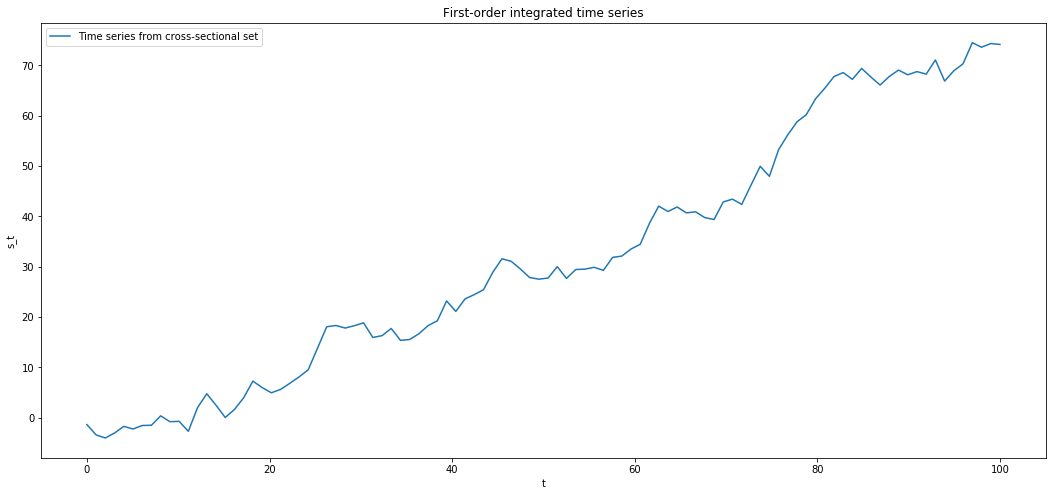

In [23]:
d = [np.random.normal(1, 2) for _ in range(0, 10**2)]
s_t = np.cumsum(d)

t = np.linspace(0, len(s_t), len(s_t))
plt.title('First-order integrated time series')
plt.plot(t, s_t, label='Time series from cross-sectional set')
plt.xlabel('t')
plt.ylabel('s_t')
plt.legend()
plt.show()

### Question 2

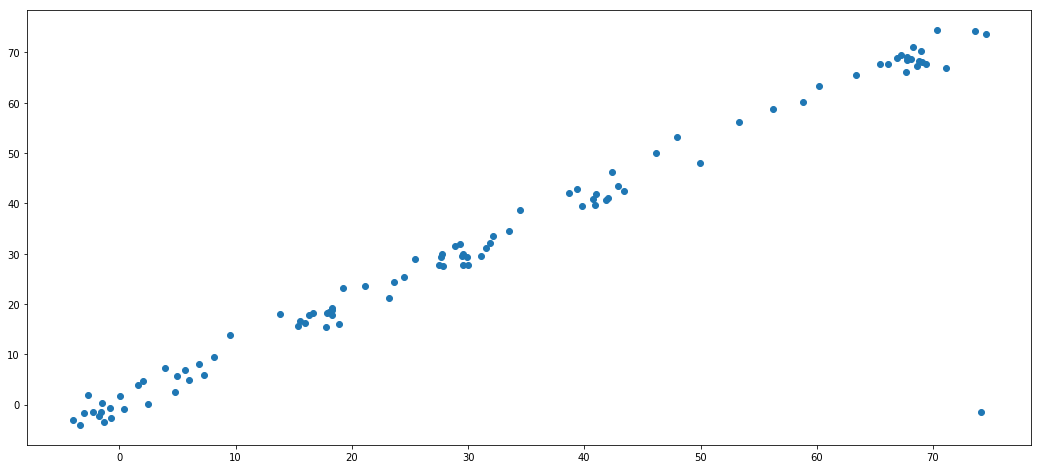

In [24]:
s_t_points = np.array([(s_t[i-1], s_t[i]) for i in range(len(s_t) -1)])
plt.scatter(s_t_points[...,0], s_t_points[...,1])
plt.show()

### Question 3

It is incorrect to fit statistical parameters to this time series because it only represents dependency between the two values of a pair in the paired dataset but does not take into account that every point in these pairs is dependent on the value of the previous point.

In [25]:
s_t_fit = [(t[i], s_t[i]) for i in range(0, len(t))]
alpha, beta, sigma = own_fit_lrm(s_t_fit)

print(alpha, beta, sigma)

0.0 0.666666666667 4.0


The theoretical expected value for sigma is given in question 1 and is: $\sigma = 2$. Known that $\mu = \alpha + \beta * x$ and when we look at the graph of question we can say that the line starts at 0. So the expected value for $\alpha$ and $\beta$ are: $\alpha = 0$ , $\beta = 1$

### Question 4

In estimating our values for sigma, we made the assumption that the sample contained independent errors. This means that the error of a predicted data point and the mean are independent from other data points. The result of this wrong assumption is that the differences between the mean and the data points are not measured correctly and thus a wrong sigma comes out.

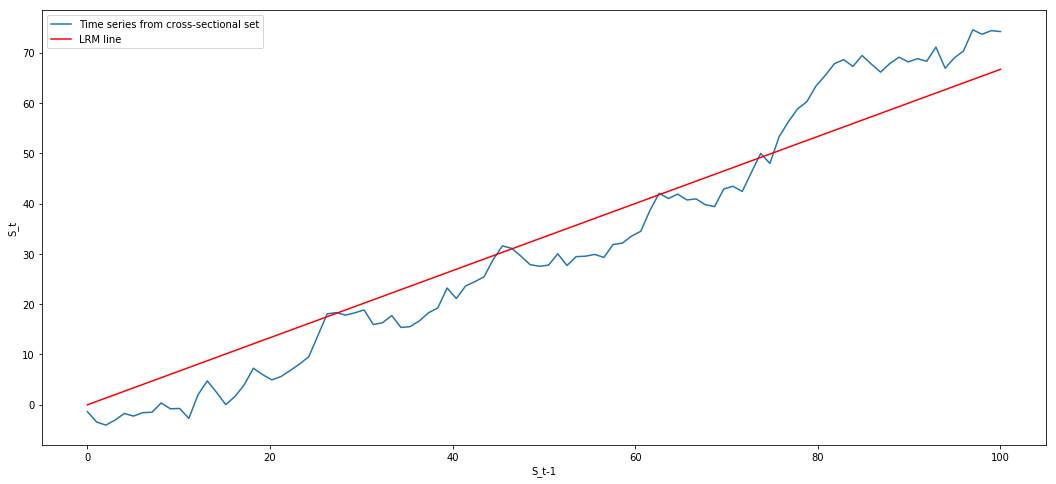

In [26]:
s_t_points = np.array([(s_t[i-1], s_t[i]) for i in range(len(s_t) -1)])
y = alpha + beta * t

plt.plot(t, s_t, label='Time series from cross-sectional set')
plt.plot(t, y, color='red', label='LRM line')
plt.xlabel('S_t-1')
plt.ylabel('S_t')
plt.legend()
plt.show()

### Question 5

Because all values for the time series are dependent on the previous one, we need to take the summation of these values into  account. When we want to calculate the mean in this case we take the difference between $S_{t_i}$ and $S_{t_{i-1}}$ and calculate the standard deviation of all of the differences in the serie.

In [27]:
differences = [s_t[i] - s_t[i-1] for i in range(1, len(s_t) -1)]

sigma = std_dev(differences)
mu = mean(differences)

### Question 6

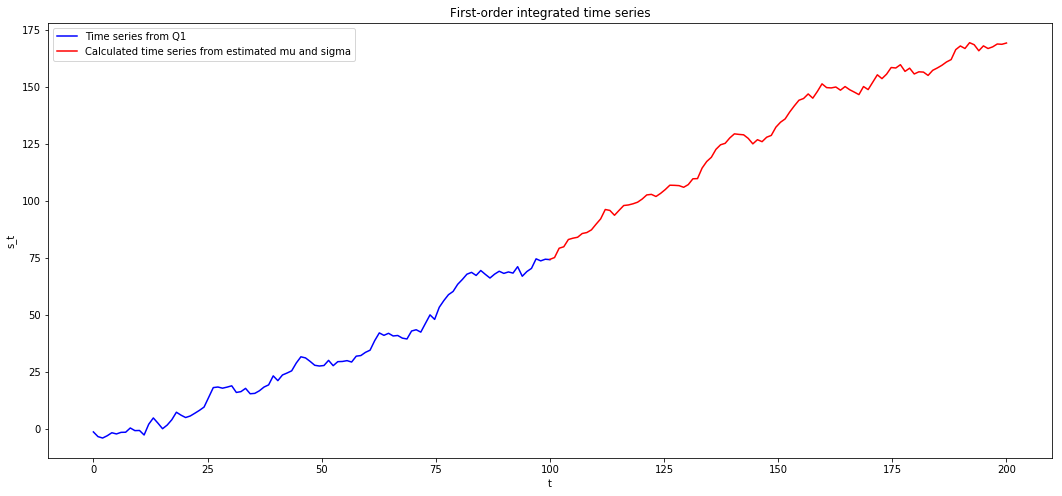

In [28]:
d_new = [np.random.normal(mu, sigma) for _ in range(10**2, 10**2 + 10**2)]

s_t = np.cumsum(np.append(d, d_new))
s_t_old = s_t[:len(d)]
s_t_new = s_t[len(d):]

t1 = np.linspace(0, len(s_t_old), len(s_t_old))
t2 = np.linspace(len(s_t_old), len(s_t_new) + len(s_t_old), len(s_t_new))

plt.title('First-order integrated time series')
plt.plot(t1, s_t_old, color='blue', label='Time series from Q1')
plt.plot(t2, s_t_new, color='red', label='Calculated time series from estimated mu and sigma')
plt.xlabel('t')
plt.ylabel('s_t')
plt.legend()
plt.show()

### Question 7

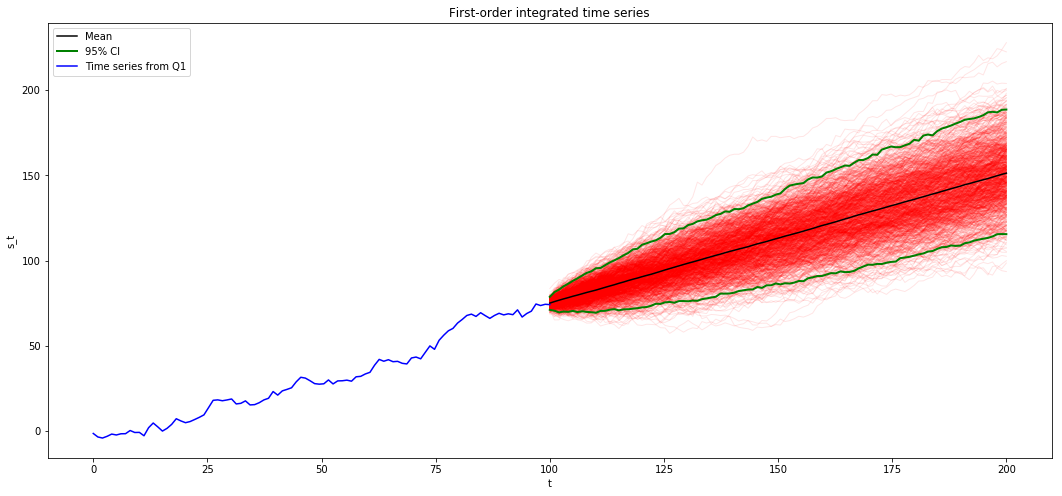

In [34]:
s_data = []

for _ in range(0, 10**3):
    d_new = [np.random.normal(mu, sigma) for _ in range(10**2, 10**2 + 10**2)]

    s_t = np.cumsum(np.append(d, d_new))
    s_t_old = s_t[:len(d)]
    s_t_new = s_t[len(d):]
    s_data.append(s_t_new)
    t1 = np.linspace(len(s_t_old) , len(s_t_new) + len(s_t_old), len(s_t_new))
    plt.plot(t1, s_t_new, color ='red', alpha=0.1, linewidth='1')

s_data = np.array(s_data)
t_mean = [mean(s_data[...,i]) for i in range(0, 10**2)]
plt.plot(t1, t_mean, label='Mean', color='black')

t_ci_lower = [lineair_percentile(s_data[...,i], 0.025) for i in range(0, 10**2)]
t_ci_upper = [lineair_percentile(s_data[...,i], 0.975) for i in range(0, 10**2)]
plt.plot(t1, t_ci_lower, linewidth=2, color='green', label='95% CI')
plt.plot(t1, t_ci_upper, linewidth=2, color='green')

t2 = np.linspace(0, len(s_t_old), len(s_t_old))
plt.title('First-order integrated time series')
plt.plot(t2, s_t_old, color='blue', label='Time series from Q1')
plt.xlabel('t')
plt.ylabel('s_t')
plt.legend()
plt.show()

Because the standard deviation of the mean gets bigger and bigger, as the curves ermege away from the mean, the range of the CI gets bigger and bigger.

### Question 8

-

### Question 9

-